#  Testing Swap Test with partial overlap
This notebook will test our swap test implementation that computes the overlap Tr$({\rho^{A}}^2)$, where now $\rho^{A}$ is a reduced density matrix of some density matrix $\rho$.

In [1]:
from sys import path
path.insert(0, '..')

from swap import *
from utilities import *
import numpy as np
import matplotlib.pyplot as plt

Let

$$
|\psi> = \frac{1}{2}\left( \sqrt{1+r}\left(|00>+ |01>\right)+\sqrt{1-r}\left(|10> - |11>\right)\right)
$$
where $0\leq r \leq 1$. Then the reduced density matrix for the first qubit is
$$\rho^{A} = \frac{I + r\sigma_{z}}{2}$$
To perform the overlap via the swap test, we'll first have to construct the quantum circuits representing these wavefunctions:

In [2]:
r1, r2 = .25, .75

#quantum circuit
psi = psi2_qc(r1) 
phi = psi2_qc(r2) 

#classical representation
psi_c = psi2_classical(r1) 
phi_c = psi2_classical(r2) 

The circuit for $|\psi>$ is drawn below:

In [3]:
psi.draw()

┌────────────┐   
q_0: ┤ RY(1.8235) ├─■─
     └───┬───┬────┘ │ 
q_1: ────┤ H ├──────■─
         └───┘

Now, let's look at the swap test quantum circuit with this wavefuntion:

In [4]:
#constructing the swap circuit
qc_swap = swap_test_QC(psi, phi, [0,1])
qc_swap.draw()

┌───┐              ┌───┐┌─┐
  a_0: ────┤ H ├─────────■──■─┤ H ├┤M├
       ┌───┴───┴────┐    │  │ └───┘└╥┘
psi_0: ┤ RY(1.8235) ├─■──X──┼───────╫─
       └───┬───┬────┘ │  │  │       ║ 
psi_1: ────┤ H ├──────■──┼──X───────╫─
       ┌───┴───┴────┐    │  │       ║ 
phi_0: ┤ RY(2.4189) ├─■──X──┼───────╫─
       └───┬───┬────┘ │     │       ║ 
phi_1: ────┤ H ├──────■─────X───────╫─
           └───┘                    ║ 
  m_0: ═════════════════════════════╩═

Now we run the simulation and obtain the overlap. Then we compare to the exact results:

In [5]:
r1 = .5
psi = psi2_qc(r1) 
psi_c = psi2_classical(r1) 
print(psi_c)

qc = measure_qc(psi)
counts = simulate_qc(qc, shots=100000)
p = get_p_from_counts(counts, 2)
p_cl = [i*i for i in psi_c]
print(p)
print(p_cl)
qc.draw()

[ 0.61237244  0.61237244  0.35355339 -0.35355339]
10 2 37347
00 0 12438
11 3 37678
01 1 12537
[0.12438 0.12537 0.37347 0.37678]
[0.37499999999999994, 0.37499999999999994, 0.12500000000000003, 0.12500000000000003]


┌───────────┐   ┌─┐   
psi_0: ┤ RY(2pi/3) ├─■─┤M├───
       └───┬───┬───┘ │ └╥┘┌─┐
psi_1: ────┤ H ├─────■──╫─┤M├
           └───┘        ║ └╥┘
  m_0: ═════════════════╩══╬═
                           ║ 
  m_1: ════════════════════╩═

WTF IS GOING ON HERE????

In [31]:
overlap_qc = swap_overlap(psi, phi, idx_list=[0,1], shots=100000)
overlap_cl = classical_overlap(psi_c, phi_c)

In [32]:
print("swap test overlap: {}".format(overlap_qc))
print("    exact overlap: {}".format(overlap_cl))
print("            error: {}".format(np.abs(overlap_qc-overlap_cl)))

swap test overlap: 0.7497400000000001
    exact overlap: 0.9139672114362376
            error: 0.16422721143623753


Now let's look at how these overlaps compare as we tune $r$

In [15]:
N = 10
r_list = np.linspace(0, 1, N)
x_list = []
o_qc_list = []
o_cl_list = []
error_list = []

for i, r1 in enumerate(r_list):
    psi = psi2_qc(r1)
    psi_c = psi2_classical(r1)
    for j, r2 in enumerate(r_list):
        phi = psi2_qc(r2)
        phi_c = psi2_classical(r2)

        x_list.append(r1-r2)
        o_qc = swap_overlap(psi, phi, idx_list=[0,1], shots=1000)
        o_cl = classical_partial_overlap(psi_c, phi_c)
        o_qc_list.append(o_qc)
        o_cl_list.append(o_cl)
        error_list.append(np.abs(o_qc - o_cl))

<IPython.core.display.Javascript object>


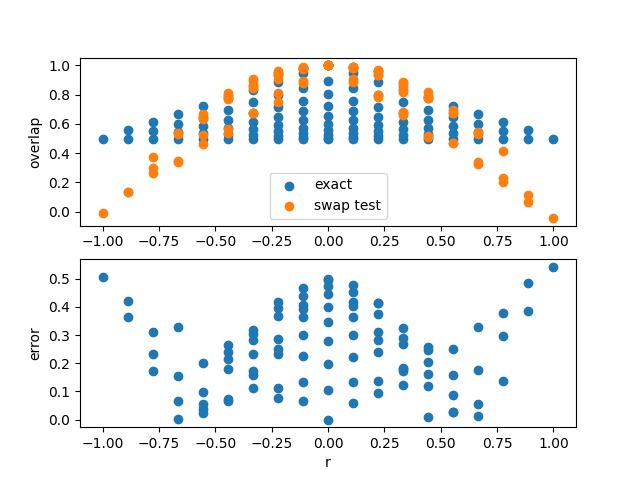

In [16]:
%matplotlib notebook

plt.subplot(211)
plt.scatter(x_list, o_cl_list, label="exact")
plt.scatter(x_list, o_qc_list, label="swap test")
plt.legend(loc='best')
plt.ylabel("overlap")
plt.subplot(212)
plt.scatter(x_list, error_list)
plt.xlabel("r")
plt.ylabel("error")
plt.show()